In [29]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

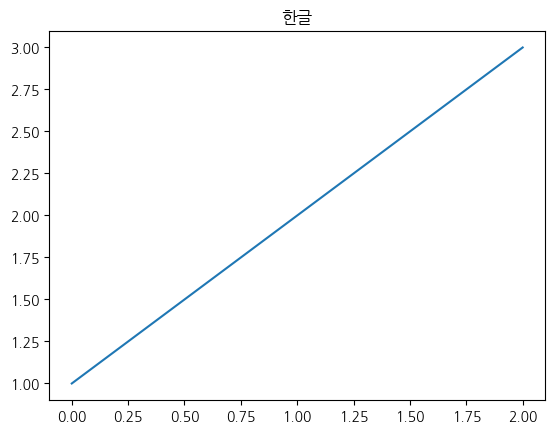

In [30]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 데이터셋 및 라이브러리 불러오기
- p214

In [7]:
import pandas as pd
from sklearn.ensemble import VotingClassifier # docs 문서링크 추가할 것
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer # 데이터 호출
from sklearn.model_selection import train_test_split # 훈련/테스트 데이터 분리
from sklearn.metrics import accuracy_score # 혼동행렬 정확도

cancer = load_breast_cancer()  # 함수 호출을 위해 괄호 추가

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(1)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0           0.1184   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.2776          0.3001               0.1471         0.2419   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33            184.6   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                   0.1189  

[1 rows x 30 columns]

In [11]:
Ir_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현하겠다.!
vo_clf = VotingClassifier(estimators = [('LR', Ir_clf),('KNN', knn_clf)], voting='soft')

# 훈련 데이터 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size =0.2, random_state=1)

# 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561


In [12]:
# 개별 모델의 학습/예측/평가
classifiers = [Ir_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train,y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__ # 각 모델의 이름 가져오기 # Docstring 문법
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9561
KNeighborsClassifier 정확도: 0.9474


KNeighborsClassifier = nearlist neighbor 이므로 가장 가까운 그룹으로 변환

In [19]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()

    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df.apply(lambda x: x['column_name'] + '_' + str(x['dup_cnt']) if x['dup_cnt'] > 0 else x['column_name'], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


def get_human_dataset( ):
    DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스/machine learning/'
    feature_name_df = pd.read_csv(DATA_PATH + '/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(DATA_PATH + '/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(DATA_PATH + '/human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(DATA_PATH + '/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(DATA_PATH + '/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환


    return X_train, X_test, y_train, y_test

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

0.9165252799457075


하이퍼 파라미터 튜닝

In [25]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_estimators":[50,100,150],
    "max_depth":[8,16,24],
    "min_samples_leaf":[1,6,12],
    "min_samples_split":[2,8,16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV
rf_clf = RandomForestClassifier(random_state =0 , n_jobs=-1)
grid_cv=GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=-1)# 병렬처리
grid_cv.fit(X_train,y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 150}
0.9170293797606093


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators = 150, min_samples_leaf=6 ~)

## GBM - 221p
- 가장 큰 단점은 속도가 매우 느림
  + 보완 : XGBoost,LightGBM


In [26]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings

warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = get_human_dataset()

### 수행시간 측정

In [28]:
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)
print("수행시간: {0:.1f}초".format(time.time() - start_time))

수행시간: 999.3초


## XGBoost
- 참조 : https://xgboost.readthedocs.io/en/stable/

In [31]:
import xgboost
print(xgboost.__version__)

1.7.6


- 교재 228p
  + 파이썬 래퍼 XGBoost 하이퍼 파리미터
    - xgboost.DMatrix() 데이터를 변환해서 사용한다!

#### step 0. 라이브러리 불러오기 & 환경설정

In [32]:
# 232p

import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### step 1. 데이터 셋 불러오기

In [35]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

dataset = load_breast_cancer()
features = dataset.data # 독립변수
labels = dataset.target # 종속변수

# 지도학습, 종속변수 존재 (분류), 초급
# 비지도학습, 종속변수 존재하지 않음 (분류 : 클러스터링) , 중급이상

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   
1                 0.05667  ...          23.41            158.8      1956.0   
2                 0.05999  ...          25.53            152.5      1709.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  

[3 rows x 31 columns]

In [36]:
print(dataset.target_names)
print (cancer_df['target'].value_counts())

# p.233 1값만 양성 benign, 0값인 삭성 malignant
# 암진단

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


### step2 데이터 분리
- 훈련데이터와 테스트 데이터로 분리

In [39]:
# 종속변수와 독립변수로 분리
X_features = cancer_df.iloc[:,:-1] # 마지막 컬럼 제외 후, 나머지 컬럼 가져오기
y_label = cancer_df.iloc[:,-1] # 마지막 컬럼만 가져오기

# X_features.shape , y_label.shape
# 전체 데이터 중 80% 학습데이터, 20% 테스트용 데이터 추출
X_train, X_test , y_train, y_test = train_test_split(X_features, y_label,test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

- (234p) 위에서 만든 X_train , y_train 다시 쪼개서 90%는 학습, 10%는 검증용으로 만듬

In [40]:
X_tr,X_val,y_tr,y_val =train_test_split(X_train, y_train,test_size=0.1, random_state=1 )
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((409, 30), (46, 30), (409,), (46,))

In [43]:
X_train.shape, X_tr.shape,X_val.shape, X_test.shape

((455, 30), (409, 30), (46, 30), (114, 30))

- X_tr : 훈련 데이터 (교과서 공부 & EBS 내 연습문제)
- X_val : 검증 데이터 (중간고사, 기말고사)
- X_test : 테스트 데이터 (평가원 모의고사)

- 실제 수능 점수

### Step 3. 데이터 변환 (XGBoost 객체)
- 오늘 핵심 코드

In [45]:
# p.234, 핵심코드!
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

### step 4. 모델링

In [46]:
# p.235

params = {
    "max_depth" : 3,
    "eta" : 0.05,
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss' # 오차
}

num_rounds = 300

# p236
# 휸련 / 검증 데이터셋
eval_list =[(dtr,'train'),(dval,'eval')]

xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds
                      , early_stopping_rounds=50, evals = eval_list)
# 학습도중 50번 연속으로 비슷한 값이 나오면 멈춘다. 그이상은 학습은 계속해도 오차가 줄어들지 않는 구간이기 때문이다.


[0]	train-logloss:0.65060	eval-logloss:0.65488
[1]	train-logloss:0.61195	eval-logloss:0.61727
[2]	train-logloss:0.57647	eval-logloss:0.58425
[3]	train-logloss:0.54399	eval-logloss:0.55342
[4]	train-logloss:0.51417	eval-logloss:0.52597
[5]	train-logloss:0.48661	eval-logloss:0.50133
[6]	train-logloss:0.46041	eval-logloss:0.47752
[7]	train-logloss:0.43681	eval-logloss:0.45606
[8]	train-logloss:0.41434	eval-logloss:0.43484
[9]	train-logloss:0.39337	eval-logloss:0.41629
[10]	train-logloss:0.37397	eval-logloss:0.39810
[11]	train-logloss:0.35621	eval-logloss:0.38231
[12]	train-logloss:0.33916	eval-logloss:0.36739
[13]	train-logloss:0.32324	eval-logloss:0.35426
[14]	train-logloss:0.30900	eval-logloss:0.34087
[15]	train-logloss:0.29508	eval-logloss:0.32830
[16]	train-logloss:0.28240	eval-logloss:0.31661
[17]	train-logloss:0.27000	eval-logloss:0.30643
[18]	train-logloss:0.25844	eval-logloss:0.29616
[19]	train-logloss:0.24800	eval-logloss:0.28604
[20]	train-logloss:0.23684	eval-logloss:0.27797
[2

### step 5. 예측

In [47]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.885 0.03  0.998 0.008 0.676 0.001 0.399 0.009 0.995 0.998]
예측값 10개만 표시: [1, 0, 1, 0, 1, 0, 0, 0, 1, 1]


### step 6. 평가

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

  # p.237
get_clf_eval(y_test,preds, pred_probs)

오차 행렬
[[37  5]
 [ 0 72]]
정확도: 0.9561, 정밀도: 0.9351, 재현율: 1.0000,    F1: 0.9664, AUC:0.9818


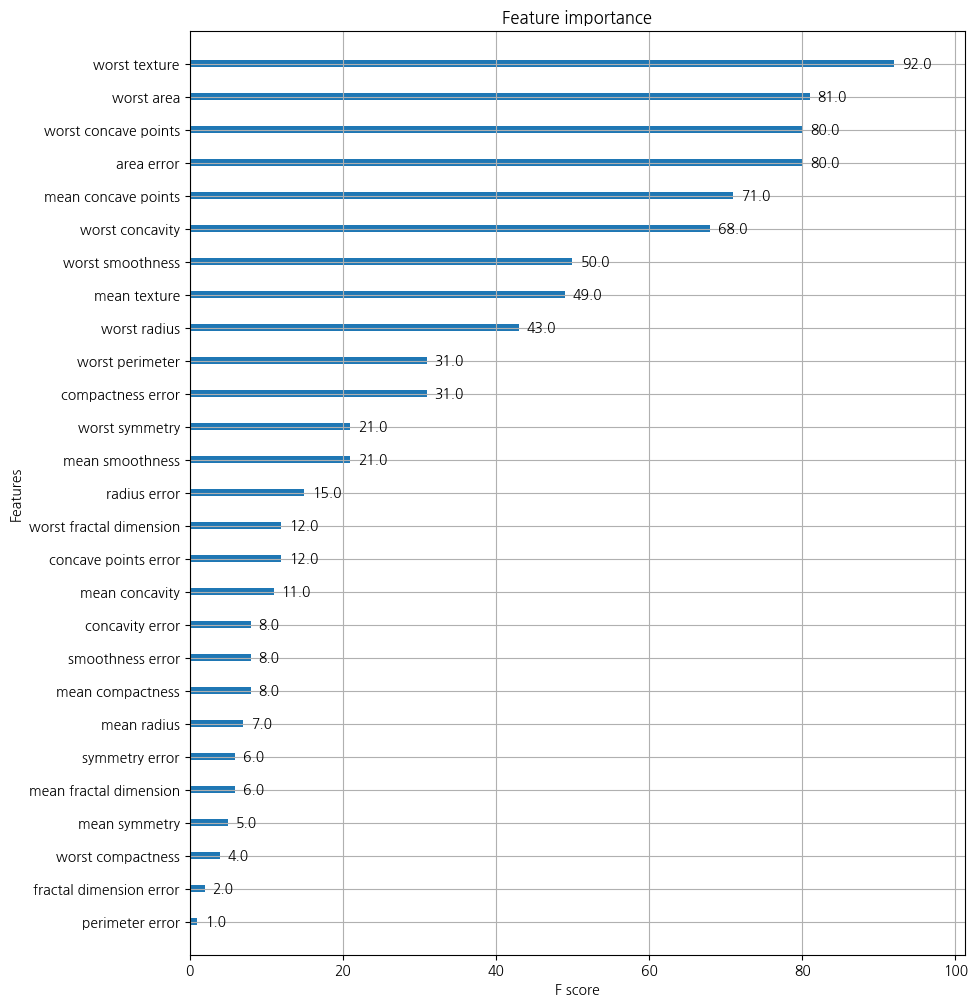

In [55]:
from ast import increment_lineno
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)
plt.show()

## LightGBM

### step 0. 라이브러리 불러오기 & 환경설정

In [56]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### step 1. 데이터셋 불러오기

In [ ]:
dataset = load_breast_cancer()
X_features = dataset.data # 독립변수
y_labels = dataset.target # 종속변수

# 지도학습, 종속변수 존재 (분류), 초급
# 비지도학습, 종속변수 존재하지 않음 (분류 : 클러스터링) , 중급이상

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_labels # 종속변수

### step 2. 데이터분리

In [57]:
# 종속변수와 독립변수로 분리
X_features = cancer_df.iloc[:,:-1] # 마지막 컬럼 제외 후, 나머지 컬럼 가져오기
y_label = cancer_df.iloc[:,-1] # 마지막 컬럼만 가져오기

# X_features.shape , y_label.shape
# 전체 데이터 중 80% 학습데이터, 20% 테스트용 데이터 추출
X_train, X_test , y_train, y_test = train_test_split(X_features, y_label,test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_tr,X_val,y_tr,y_val =train_test_split(X_train, y_train,test_size=0.1, random_state=1 )
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

X_train.shape, X_tr.shape,X_val.shape, X_test.shape

((455, 30), (409, 30), (46, 30), (114, 30))

### Step 3. 모델링
- 사이킷런 래퍼 형태로 진행
- 미니 과제 : python 래퍼 형태로 변경해서 코드를 완성
  + 해도 그만! 안해도 그만! 그런데 했음 좋겠다!!

In [60]:
# p.251
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50,
                 eval_metric='logloss', eval_set=evals, verbose=True)


[1]	training's binary_logloss: 0.624104	valid_1's binary_logloss: 0.592866
[2]	training's binary_logloss: 0.58771	valid_1's binary_logloss: 0.560915
[3]	training's binary_logloss: 0.554888	valid_1's binary_logloss: 0.53221
[4]	training's binary_logloss: 0.524627	valid_1's binary_logloss: 0.504594
[5]	training's binary_logloss: 0.497213	valid_1's binary_logloss: 0.480463
[6]	training's binary_logloss: 0.471894	valid_1's binary_logloss: 0.456813
[7]	training's binary_logloss: 0.44732	valid_1's binary_logloss: 0.434369
[8]	training's binary_logloss: 0.42595	valid_1's binary_logloss: 0.414447
[9]	training's binary_logloss: 0.40544	valid_1's binary_logloss: 0.397207
[10]	training's binary_logloss: 0.385891	valid_1's binary_logloss: 0.379056
[11]	training's binary_logloss: 0.368685	valid_1's binary_logloss: 0.363633
[12]	training's binary_logloss: 0.351235	valid_1's binary_logloss: 0.348958
[13]	training's binary_logloss: 0.335855	valid_1's binary_logloss: 0.335922
[14]	training's binary_log

LGBMClassifier(learning_rate=0.05, n_estimators=400)

### step 4. 예측

In [62]:
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1] # 4.0버전에서 이 코드가 안된다.

### step 5. 평가

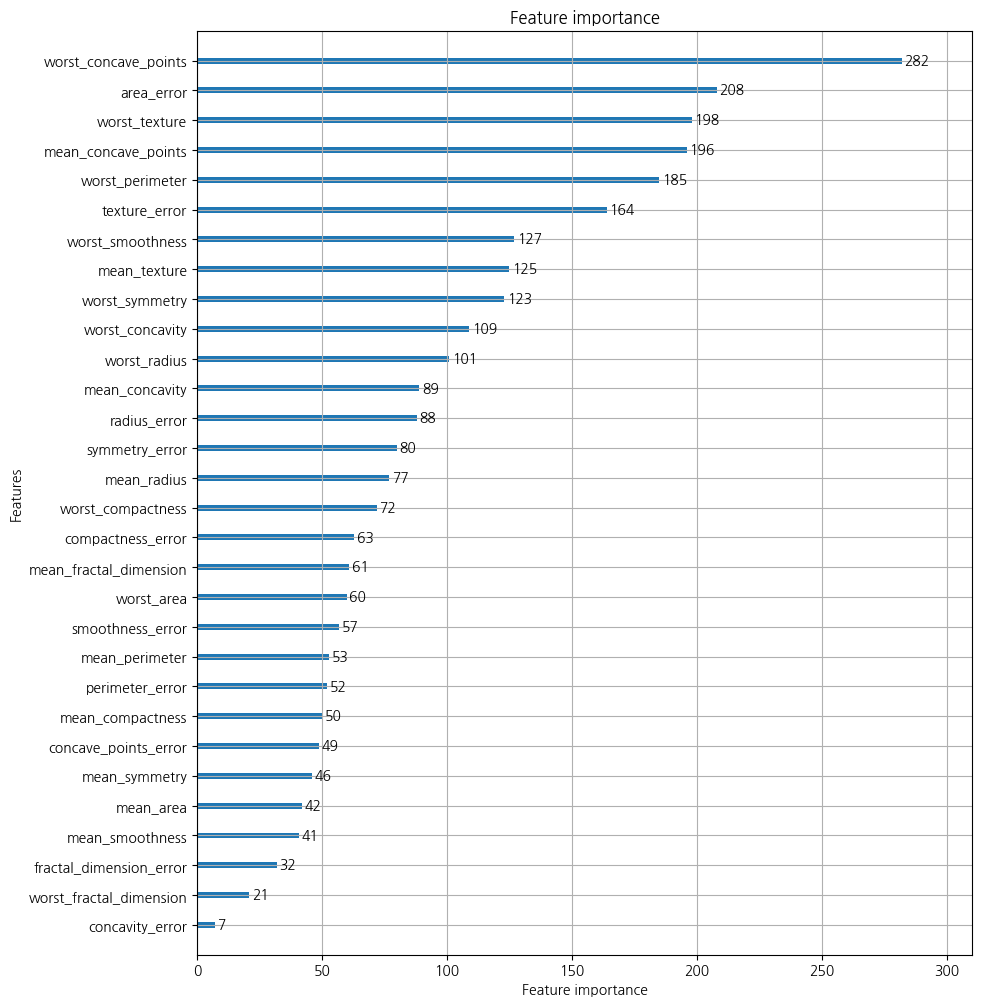

In [65]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 253, number of negative: 156
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618582 -> initscore=0.483533
[LightGBM] [Info] Start training from score 0.483533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.592866
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.561355
[LightGBM] [Warning] No further splits with positive gain, bes

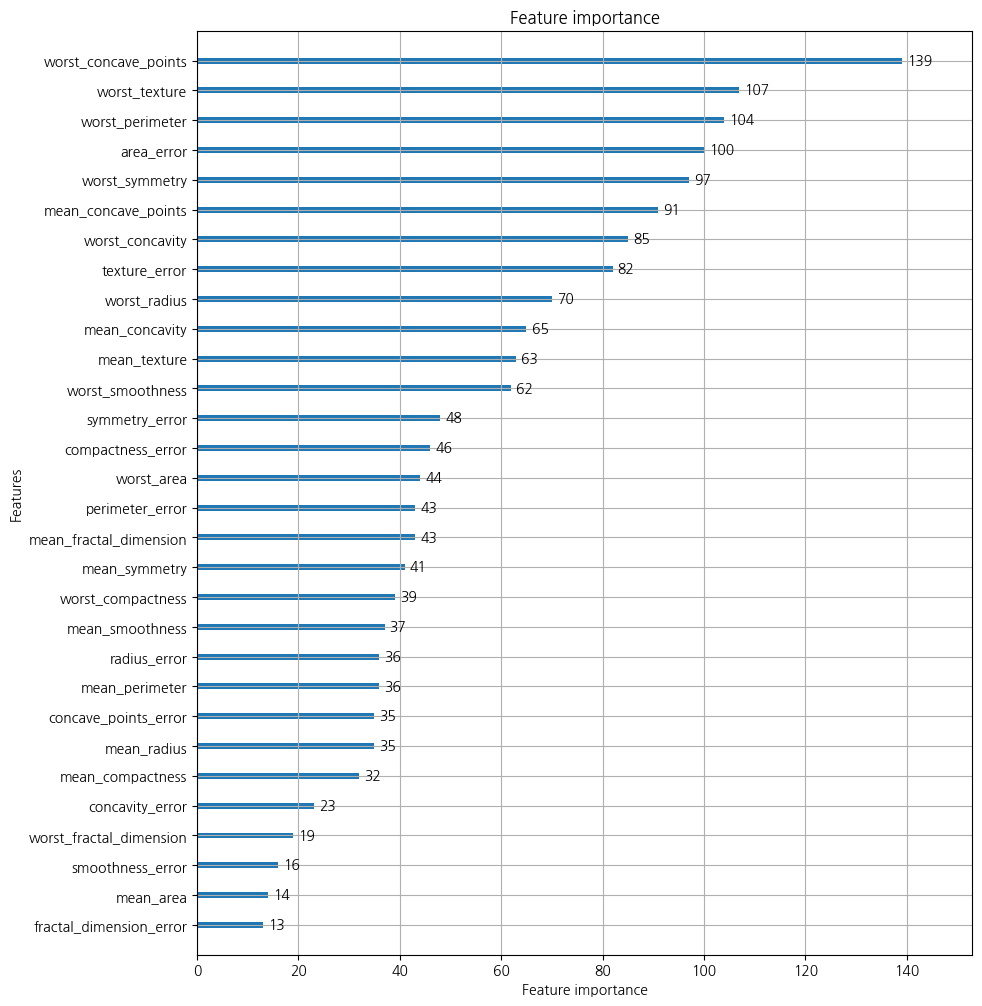

In [66]:
import lightgbm as lgb

# 1. 데이터셋을 LightGBM의 데이터셋 형식으로 변환
train_dataset = lgb.Dataset(X_tr, label=y_tr)
valid_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

# 2. 훈련 매개변수를 설정
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# 3. 모델을 훈련
num_round = 400
lgbm_model = lgb.train(params, train_dataset, num_round, valid_sets=valid_dataset, early_stopping_rounds=50)

# 4. 피처 중요도를 시각화
fig, ax = plt.subplots(figsize=(10,12))
lgb.plot_importance(lgbm_model, ax=ax)
plt.show()
